# Importing the necessary libraries
First, I import the relevant libraries. Apart from the standard libraries pandas, numpy and matplotlib, I am using seaborn for the visualization of .... and sklearn for the different analyses. I set the style of the seaborn plots to whitegrid. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from IPython.display import display
from pathlib import Path
sns.set(style="whitegrid")

# Data reading and initial inspection
First, I load the data from the xsl file and perform some initial validation of the datatypes. I read the xsl file into a dataframe, check for NaN entries, missing values and duplicates. I am also checking that the datatype matches the datatype in the description. 

In [87]:
# Defining the folder structure
data_folder = Path("./data/")
results_folder = Path("./results/")
file_name = "Loan.xlsx"
df = pd.read_excel(str(data_folder / file_name))

In [88]:
df.head()


,OBS#,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIO/TV,EDUCATION,RETRAINING,...,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
0,1,0,6,4,0,0,0,1,0,0,...,67,0,0,1,2,2,1,1,0,1
1,2,1,48,2,0,0,0,1,0,0,...,22,0,0,1,1,2,1,0,0,0
2,3,3,12,4,0,0,0,0,1,0,...,49,0,0,1,1,1,2,0,0,1
3,4,0,42,2,0,0,1,0,0,0,...,45,0,0,0,1,2,2,0,0,1
4,5,0,24,3,1,0,0,0,0,0,...,53,0,0,0,2,2,2,0,0,0


## Data Validation
### Step 1: Explore Dataset Information

Comparing the the Data and Data dictionary sheet to check column names and identify the the variable type

In [48]:
def create_data_dict(sheet):
    data_dict = {}

    for _, row in sheet.iterrows():
        variable_name = row['Variable Name']
        variable_type = row['Variable Type']
        if(variable_name == "MALE_MAR_WID"):
            variable_name = "MALE_MAR_or_WID"

        # Determine type and valid range based on the Variable Type
        if pd.isna(variable_name):
            continue
        if variable_type == 'Categorical':
            # Extracting range from Code Description and converting to list of ints
            # valid_values = [int(x.strip()) for x in row['Code Description'].split(":")[0].split(",")]
            data_dict[variable_name] = {"type": "categorical"}#, "range": valid_values}
        elif variable_type == 'Binary':
            valid_values = [0, 1]
            data_dict[variable_name] = {"type": "binary", "range": valid_values}
        elif variable_type == 'Numerical':
            data_dict[variable_name] = {"type": "numerical"}
        else:
            print(f"Unknown data type for {variable_name}")

    return data_dict

# Load Data Dictionary sheet
data_dictionary_sheet = pd.read_excel(str(data_folder / file_name), sheet_name='Data Dictionary', skiprows=[0])

data_sheet = pd.read_excel(str(data_folder / file_name), sheet_name='Data')

data_dict = create_data_dict(data_dictionary_sheet)
print(data_dict)

{'OBS#': {'type': 'categorical'}, 'CHK_ACCT': {'type': 'categorical'}, 'DURATION': {'type': 'numerical'}, 'HISTORY': {'type': 'categorical'}, 'NEW_CAR': {'type': 'binary', 'range': [0, 1]}, 'USED_CAR': {'type': 'binary', 'range': [0, 1]}, 'FURNITURE': {'type': 'binary', 'range': [0, 1]}, 'RADIO/TV': {'type': 'binary', 'range': [0, 1]}, 'EDUCATION': {'type': 'binary', 'range': [0, 1]}, 'RETRAINING': {'type': 'binary', 'range': [0, 1]}, 'AMOUNT': {'type': 'numerical'}, 'SAV_ACCT': {'type': 'categorical'}, 'EMPLOYMENT': {'type': 'categorical'}, 'INSTALL_RATE': {'type': 'numerical'}, 'MALE_DIV': {'type': 'binary', 'range': [0, 1]}, 'MALE_SINGLE': {'type': 'binary', 'range': [0, 1]}, 'MALE_MAR_or_WID': {'type': 'binary', 'range': [0, 1]}, 'CO-APPLICANT': {'type': 'binary', 'range': [0, 1]}, 'GUARANTOR': {'type': 'binary', 'range': [0, 1]}, 'PRESENT_RESIDENT': {'type': 'categorical'}, 'REAL_ESTATE': {'type': 'binary', 'range': [0, 1]}, 'PROP_UNKN_NONE': {'type': 'binary', 'range': [0, 1]}, '

In [77]:
df.columns

Index(['OBS#', 'CHK_ACCT', 'DURATION', 'HISTORY', 'NEW_CAR', 'USED_CAR',
       'FURNITURE', 'RADIO/TV', 'EDUCATION', 'RETRAINING', 'AMOUNT',
       'SAV_ACCT', 'EMPLOYMENT', 'INSTALL_RATE', 'MALE_DIV', 'MALE_SINGLE',
       'MALE_MAR_or_WID', 'CO-APPLICANT', 'GUARANTOR', 'PRESENT_RESIDENT',
       'REAL_ESTATE', 'PROP_UNKN_NONE', 'AGE', 'OTHER_INSTALL', 'RENT',
       'OWN_RES', 'NUM_CREDITS', 'JOB', 'NUM_DEPENDENTS', 'TELEPHONE',
       'FOREIGN', 'RESPONSE'],
      dtype='object')

### Step 2: Check for Missing Values

To ensure the quality and reliability of our data, it's crucial to identify and handle missing values appropriately. Missing values can affect the accuracy of our analysis and modeling.

We'll start by checking for missing values in our dataset using the following code to calculate the percentages:

In [41]:
missing = df.isnull().sum() / len(df) * 100
for column in missing:
    if column > 0:
        print("Missing column found")
print("Missing column not found")

Missing column not found


### Step 3: Identify and Handle Duplicate Rows

Duplicate rows in a dataset can arise due to various reasons, such as data entry errors or data collection methods. Identifying and handling duplicate rows is crucial to ensure the integrity of the analysis and modeling process. Duplicate rows can potentially lead to biased results and incorrect insights.

The `data.duplicated()` function can be used to identify duplicate rows in the dataset. It returns a Boolean Series where `True` indicates a duplicated row.

In [40]:
duplicate_mask = df.duplicated()
for duplicate in duplicate_mask:
    if duplicate == True:
        print("Duplicates found")
print("Duplicates not found")

Duplicates not found


# Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves summarizing, visualizing, and understanding the main characteristics of a dataset. EDA helps data scientists and analysts to gain insights into the data, identify patterns, and uncover potential relationships between variables. It is often the first step before building predictive models or making informed decisions based on the data.

EDA includes various techniques such as data visualization, summary statistics, and data cleaning. It helps in understanding the distribution of variables, detecting outliers, identifying missing values, and revealing any potential data quality issues.

## Using the `describe()` Function

The `describe()` function is a powerful tool to get a quick overview of the main statistics of numerical variables in a dataset. It provides statistics such as mean, standard deviation, minimum, maximum, and quartiles for each numerical column. This function helps in understanding the central tendency, spread, and shape of the data.

In [6]:
numerical = ["AMOUNT", "INSTALL_RATE", "AGE", "NUM_CREDITS", "NUM_DEPENDENTS"]
data_summary = df[numerical].describe()
data_summary

,AMOUNT,INSTALL_RATE,AGE,NUM_CREDITS,NUM_DEPENDENTS
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3271.258000,2.973000,35.546000,1.407000,1.155000
std,2822.736876,1.118715,11.375469,0.577654,0.362086
min,250.000000,1.000000,19.000000,1.000000,1.000000
25%,1365.500000,2.000000,27.000000,1.000000,1.000000
50%,2319.500000,3.000000,33.000000,1.000000,1.000000
75%,3972.250000,4.000000,42.000000,2.000000,1.000000
max,18424.000000,4.000000,75.000000,4.000000,2.000000


# Visualizations

### Target Variable

We will first look at the target variable, ```RESPONSE```. As it is a categorical variable, let us look at its ```frequency table, percentage distribution, and bar plot.```

The ```frequency table``` of a variable will give us the count of each category in that variable.

Normalize can be set to True to print proportions instead of number

### Insight
Here we see that the number of people whose credit ratings are more than that of people with bad credit rating

In [7]:
# Frequency table
df.RESPONSE.value_counts(normalize=True)

RESPONSE
1    0.7
0    0.3
Name: proportion, dtype: float64

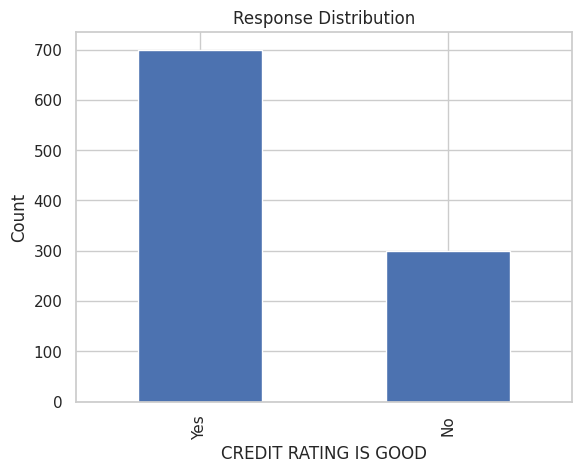

In [18]:
# Bar plot
df.RESPONSE.value_counts().plot.bar();
plt.xticks([1, 0], ['No', 'Yes'])
plt.xlabel('CREDIT RATING IS GOOD')
plt.ylabel('Count')
plt.title('Response Distribution')
plt.show()

# INDEPENDENT CATEGORICAL VARIABLES

In this section, we explore visualizations for some of the categorical independent variables. These visualizations provide insights into the distribution of various categorical features that may influence the credit rating.

## Selected Categorical Variables

We will be visualizing the following categorical variables:

- `EMPLOYMENT`: Present employment status of applicants.
- `NUM_CREDITS`: Number of existing credits at the bank.
- `REAL_ESTATE`: Ownership of real estate.


### REAL ESTATE DISTRIBUTION
The visualization showcases whether owning real estate has an impact on credit ratings. Interestingly, we observe that the number of people who don't own real estate is more than those who do own. This information could provide valuable insights into the relationship between real estate ownership and creditworthiness.

These visualizations offer initial insights into the distribution of selected categorical variables and their potential influence on credit ratings.

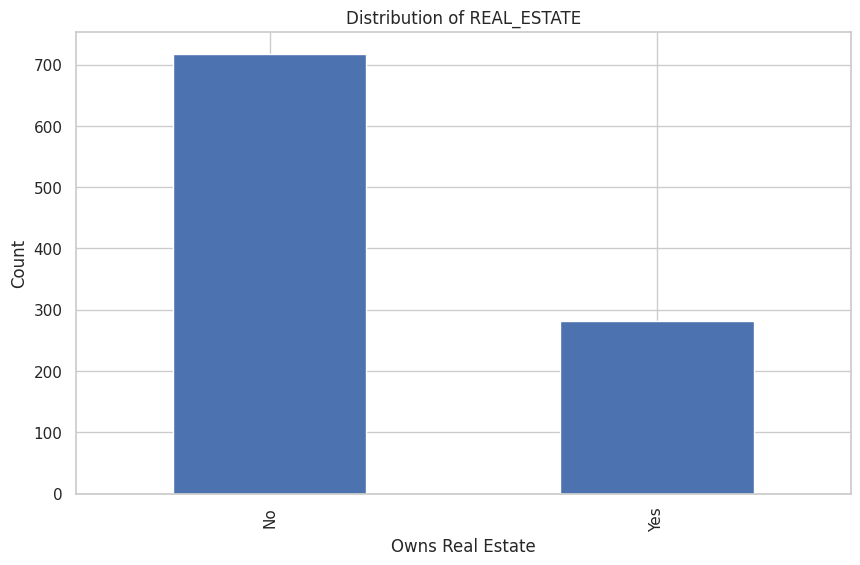

In [76]:
plt.figure(figsize=(10, 6))
labels = {
    0: "No",
    1: "Yes",
}
df["REAL_ESTATE"].value_counts().rename(index=labels).plot.bar()
plt.title("Distribution of REAL_ESTATE")
plt.ylabel("Count")
plt.xlabel("Owns Real Estate");


### JOB TYPE DISTRIBUTION

Let's examine the distribution of job types in the dataset:


From the visualization, we observe the distribution of job types among the applicants. The categories are ranked as follows based on frequency: skilled employee / official, unskilled - resident, management, and unemployed/ unskilled - non-resident. This information provides an insight into the job distribution of applicants and its potential impact on credit ratings.

These visualizations offer initial insights into the distribution of selected categorical variables and their potential influence on credit ratings.

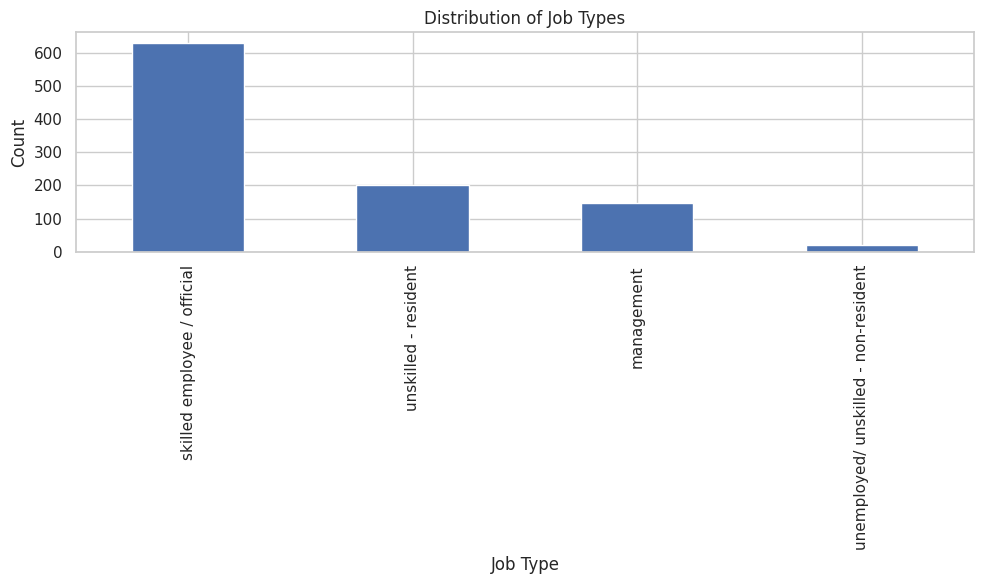

In [63]:
# Plot 2: JOB value counts with custom labels
plt.figure(figsize=(10, 6))
job_labels = {
    0: "unemployed/ unskilled - non-resident",
    1: "unskilled - resident",
    2: "skilled employee / official",
    3: "management"
}
df['JOB'].value_counts().rename(index=job_labels).plot.bar()
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.title('Distribution of Job Types')

# Display the plots
plt.tight_layout()
plt.show()

# INDEPENTENT NUMERICAL VARIABLES
Here we look at the visualizations for independent numerical variable, they include ```AMOUNT, INSTALL_RATE, AGE, NUM_CREDITS,``` and ```NUM_DEPENDENTS```

Here we will look some important visualizations for AMOUNT and INSTALL_RATE

## 1: CREDIT AMOUNT DISTRIBUTION

When analyzing the `AMOUNT` feature, we aimed to understand its distribution and identify any potential patterns. The visualization below provides insights into the distribution of applicant income:


From the visualization, we can infer the following:

- Most of the data in the distribution of `AMOUNT` is skewed towards the left. This suggests that a significant number of applicants have lower credit amounts, while fewer applicants have higher credit amounts.

This observation provides a preliminary understanding of the distribution of the `AMOUNT` feature. Further analysis and modeling can be conducted to explore its relationship with the target variable and other features.

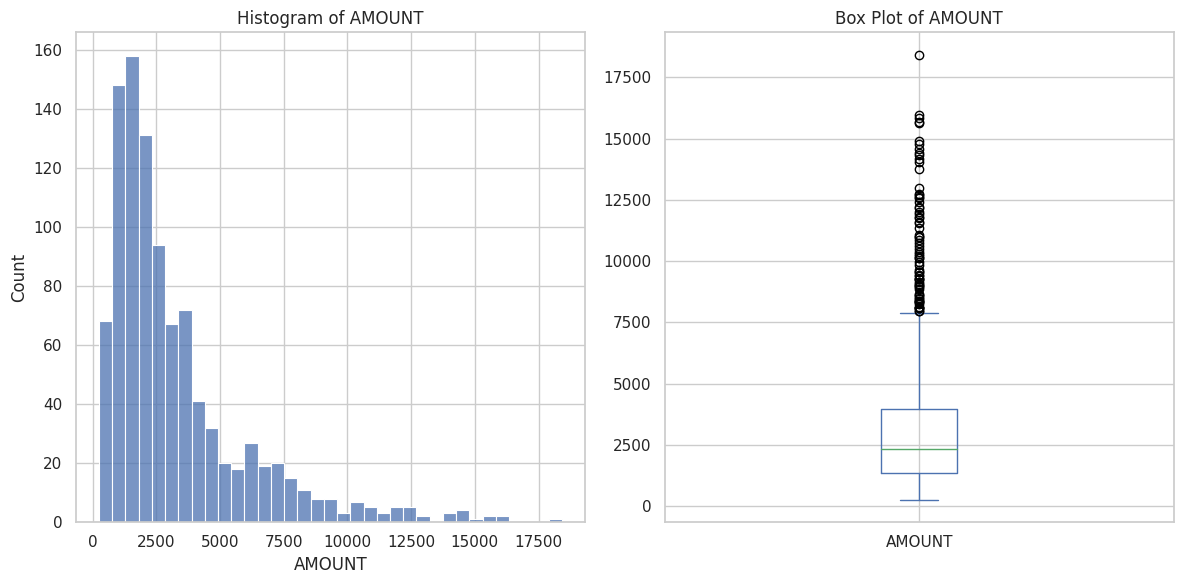

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Create a subplot for the histogram
sns.histplot(df['AMOUNT'])
plt.title('Histogram of AMOUNT')

plt.subplot(1, 2, 2)  # Create a subplot for the box plot
df['AMOUNT'].plot.box()
plt.title('Box Plot of AMOUNT')

plt.tight_layout()  # Adjust layout for better spacing between plots
plt.show()

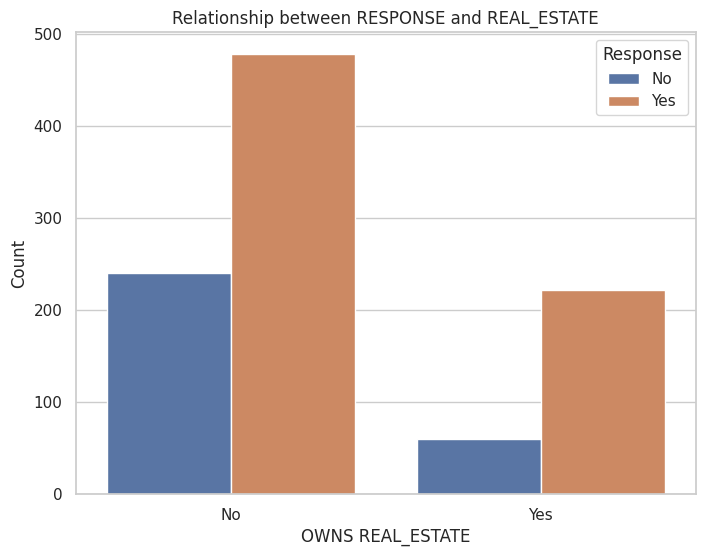

In [12]:
plt.figure(figsize=(8, 6))

sns.countplot(data=df, x='REAL_ESTATE', hue='RESPONSE')
plt.xticks([0, 1], ["No", "Yes"])
plt.xlabel('OWNS REAL_ESTATE')
plt.ylabel('Count')
plt.title('Relationship between RESPONSE and REAL_ESTATE')
plt.legend(title='Response', labels=['No', 'Yes'])

plt.show()

## Model Building

In this stage, we'll build a predictive model to classify whether a person is a good or bad credit risk based on the provided attributes. We'll follow these steps:


1. **Train-Test Split:**
   - Split the data into training and testing sets using a suitable ratio (e.g., 80% train, 20% test).

In [19]:
target = "RESPONSE"
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

4. **Model Selection:**
   - Choose a suitable algorithm for classification. In this case, we'll use a Decision Tree classifier due to its ability to handle both categorical and numerical data.

5. **Model Training:**
   - Train the Decision Tree classifier on the training data.

In [20]:
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

6. **Model Evaluation:**
   - Evaluate the model's performance on the test data using appropriate metrics such as accuracy, precision, recall, and F1-score.
   - Visualize the confusion matrix to understand the true positive, true negative, false positive, and false negative predictions.

In [23]:
y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1])

In [24]:
cls_report = confusion_matrix(y_test, y_pred)
cls_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.50      0.56        52
           1       0.84      0.90      0.87       148

    accuracy                           0.80       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.78      0.80      0.79       200



7. **Feature Importance:**
   - Analyze the importance of each feature in the Decision Tree model. This can provide insights into which attributes are most predictive of credit risk.

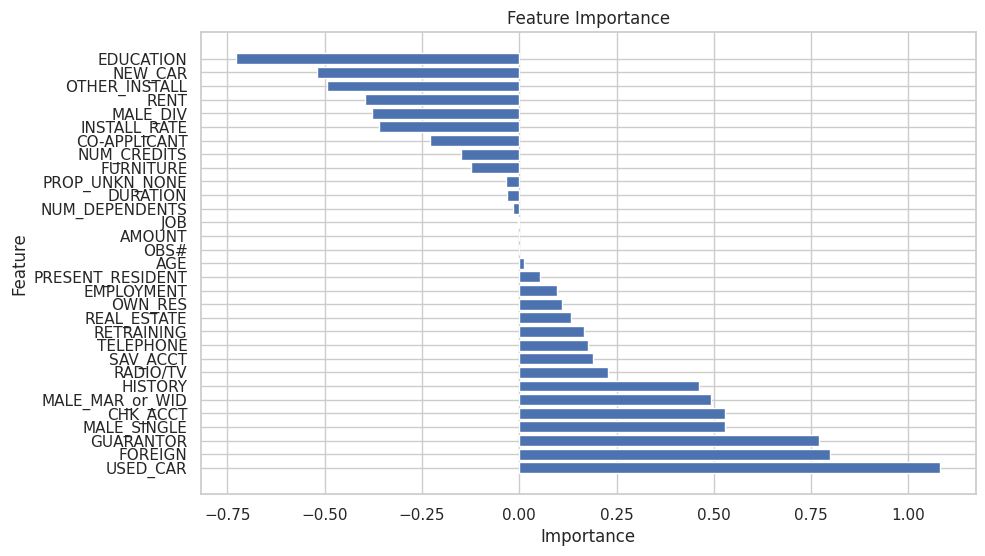

In [19]:
# Calculate feature importances using coefficients
importances = model.coef_[0]

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [80]:
# Creating a Basic Scorecard (simplified approach)
applicant_scores = X_test.dot(model.coef_[0])
print("Applicant Scores:")
print(applicant_scores)

Applicant Scores:
244    1.125161
486    2.684751
933    3.666578
550    2.933024
24     4.534159
         ...   
423    2.123383
90     3.356198
865    1.550760
870    1.615167
529    0.394972
Length: 200, dtype: float64
